
### **Mounting Google Drive**




In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow==2.13.0

import tensorflow as tf
print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 117.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 47.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12

#My helper function .py


In [50]:
import os
!wget https://raw.githubusercontent.com/kcanmersin/Google-Colab-Notebooks/main/KC_helper.py

--2023-08-08 20:25:14--  https://raw.githubusercontent.com/kcanmersin/Google-Colab-Notebooks/main/KC_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9499 (9.3K) [text/plain]
Saving to: ‘KC_helper.py’

KC_helper.py        100%[===================>]   9.28K  --.-KB/s    in 0s      

2023-08-08 20:25:15 (87.9 MB/s) - ‘KC_helper.py’ saved [9499/9499]



### **Importing other  Packages**

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow_datasets as tfds
import seaborn as sn

from KC_helper import create_tensorboard_callback, plot_loss_curves, compare_historys

## **Downloand data**




In [9]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteJFK9Y0/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteJFK9Y0/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [52]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
train_one_sample = train_data.take(1)

In [12]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image Datatype : {image.dtype}
  Class : {class_names[label.numpy()]}
  """)


  Image Shape : (512, 512, 3)
  Image Datatype : <dtype: 'uint8'>
  Class : huevos_rancheros
  


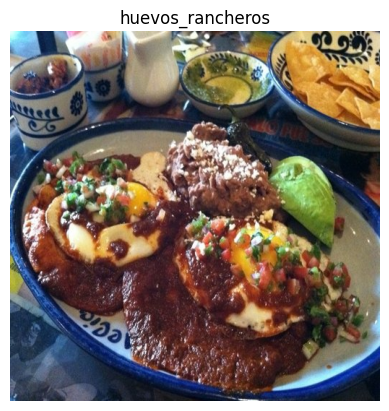

In [53]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## **Preprocessing the Data**



In [15]:
def preprocess_img(image, label, img_size=224):
  image = tf.image.resize(image, [img_size, img_size])
  image = tf.cast(image, tf.float16)
  return image, label

In [17]:
train_data = train_data.map(preprocess_img, tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, tf.data.AUTOTUNE)
test_data = test_data.batch(32)

In [ ]:
train_data

In [ ]:
test_data

## **Building the Model : EfficientNetB1**



#Callbacks

In [19]:
# EarlyStopping Callback

early_stopping_callback = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3, verbose=1, monitor="val_accuracy")

In [20]:
# ReduceLROnPlateau Callback

lower_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-7,
                                                patience=0,
                                                verbose=1)



### **Mixed Precision Training**


In [21]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [22]:
mixed_precision.global_policy()

<Policy "mixed_float16">



### **Building the Model**

In [23]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create base model

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB1(include_top=False)



inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)


x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(.3)(x)

x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

27018416/27018416 [==============================] - 3s 0us/step


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, None, None, 1280   6575239   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0     

In [25]:
history = model.fit(train_data,
                    epochs=50,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[create_tensorboard_callback("training-logs", "EfficientNetB1-"),
                               early_stopping_callback,
                               lower_lr])

Saving TensorBoard log files to: training-logs/EfficientNetB1-/20230808-171732
Epoch 1/50
2368/2368 [==============================] - 674s 247ms/step - loss: 1.7486 - accuracy: 0.5559 - val_loss: 1.0933 - val_accuracy: 0.6973 - lr: 0.0010
Epoch 2/50
2368/2368 [==============================] - 592s 247ms/step - loss: 1.1393 - accuracy: 0.6974 - val_loss: 1.0220 - val_accuracy: 0.7203 - lr: 0.0010
Epoch 3/50
2368/2368 [==============================] - 605s 253ms/step - loss: 0.9310 - accuracy: 0.7454 - val_loss: 0.9147 - val_accuracy: 0.7421 - lr: 0.0010
Epoch 4/50
2368/2368 [==============================] - 593s 248ms/step - loss: 0.7688 - accuracy: 0.7871 - val_loss: 0.8773 - val_accuracy: 0.7691 - lr: 0.0010
Epoch 5/50
2368/2368 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.8125
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 597s 250ms/step - loss: 0.6562 - accuracy: 0.8125 - val_l

In [26]:
# Saving the model
model.save("/content/drive/My Drive/Fin alModel.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


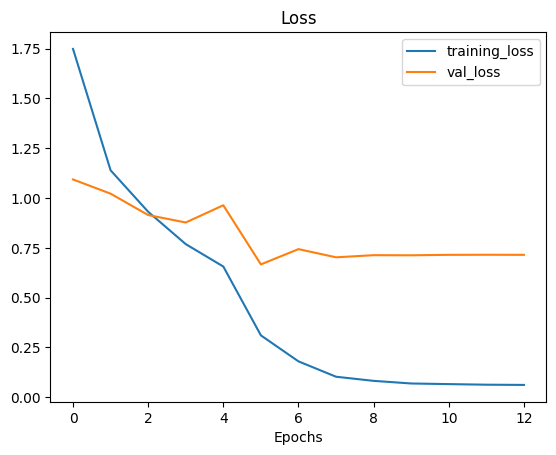

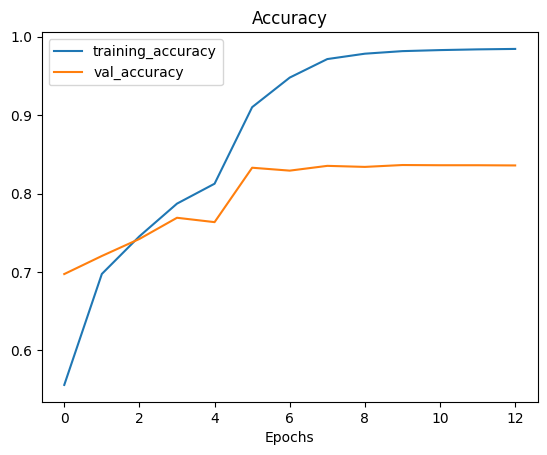

In [27]:
plot_loss_curves(history)

In [28]:
model.evaluate(test_data)

790/790 [==============================] - 67s 85ms/step - loss: 0.7189 - accuracy: 0.8367


[0.7188891768455505, 0.8366732597351074]

In [47]:
model.evaluate(test_data)

790/790 [==============================] - 69s 87ms/step - loss: 0.7189 - accuracy: 0.8367


[0.7188891768455505, 0.8366732597351074]

## **Evaluate the model**

In [56]:
pred_probs = model.predict(test_data, verbose=1)
len(pred_probs), pred_probs.shape

790/790 [==============================] - 63s 80ms/step


(25250, (25250, 101))

In [57]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250, (25250,))

In [58]:

y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

### **Accuracy Score**

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_labels, pred_classes, average='weighted')
recall = recall_score(y_labels, pred_classes, average='weighted')
f1 = f1_score(y_labels, pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Precision: 0.8369926536067704
Recall: 0.8366732673267326
F1-Score: 0.8363389064908926


### **Confusion Matrix**


In [35]:
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (200, 200));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues');

### **Accuracy according to label**

In [36]:
from sklearn.metrics import classification_report
report = (classification_report(y_labels, pred_classes, output_dict=True))

In [37]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in report.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.6117136659436009,
 'baby_back_ribs': 0.8356997971602435,
 'baklava': 0.8769841269841269,
 'beef_carpaccio': 0.8928571428571428,
 'beef_tartare': 0.7903225806451615,
 'beet_salad': 0.7413441955193483,
 'beignets': 0.8815533980582525,
 'bibimbap': 0.9492900608519269,
 'bread_pudding': 0.6639004149377593,
 'breakfast_burrito': 0.7692307692307692,
 'bruschetta': 0.7934560327198364,
 'caesar_salad': 0.8771929824561403,
 'cannoli': 0.9087221095334685,
 'caprese_salad': 0.8423076923076923,
 'carrot_cake': 0.8139534883720929,
 'ceviche': 0.7219917012448134,
 'cheesecake': 0.7254509018036074,
 'cheese_plate': 0.882703777335984,
 'chicken_curry': 0.7743271221532091,
 'chicken_quesadilla': 0.8263473053892215,
 'chicken_wings': 0.8848484848484848,
 'chocolate_cake': 0.721311475409836,
 'chocolate_mousse': 0.6242774566473989,
 'churros': 0.9171717171717173,
 'clam_chowder': 0.8960000000000001,
 'club_sandwich': 0.8817635270541083,
 'crab_cakes': 0.7695238095238095,
 'creme_brulee': 

In [38]:
report_df = pd.DataFrame(class_f1_scores, index = ['f1-scores']).T

In [39]:
report_df = report_df.sort_values("f1-scores", ascending=True)

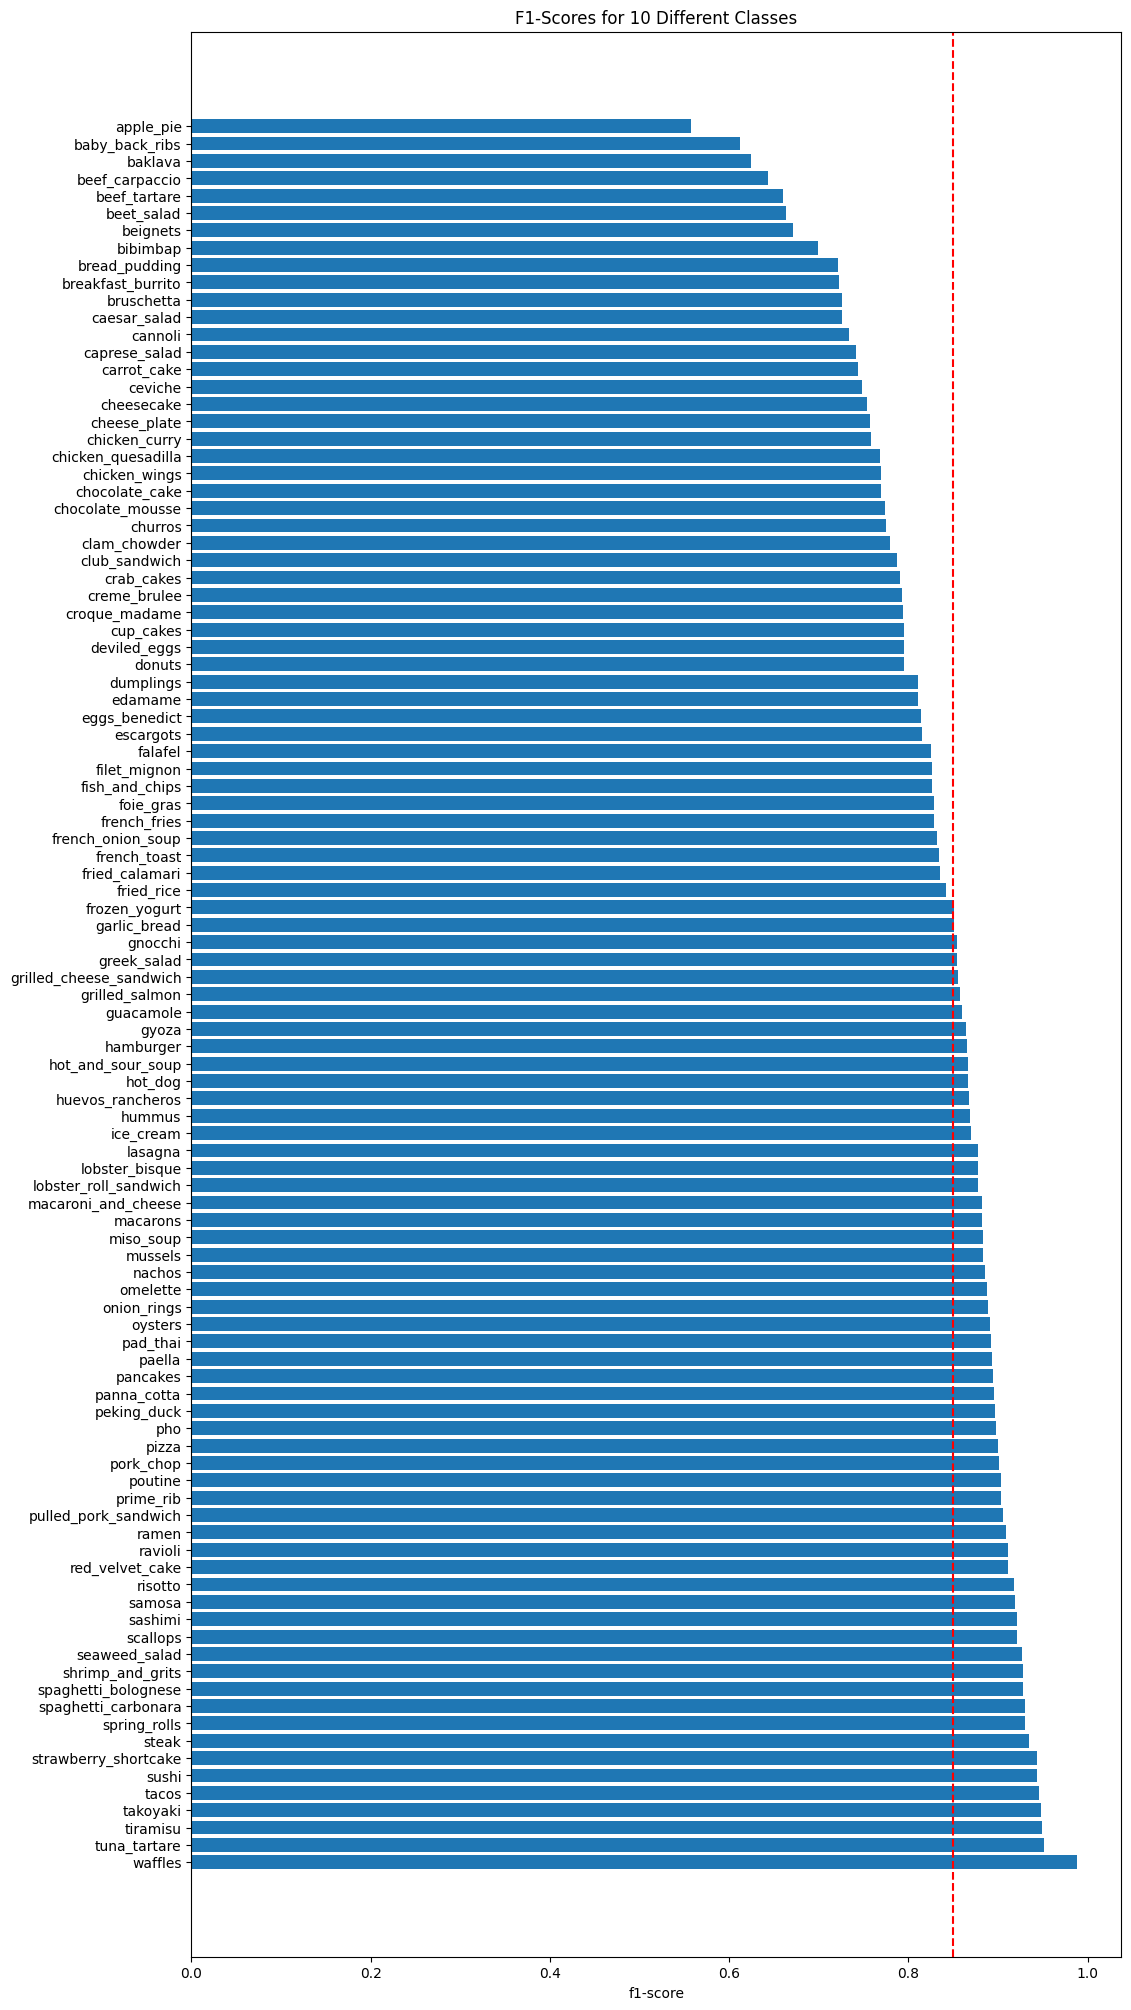

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(report_df)), report_df["f1-scores"].values)
ax.set_yticks(range(len(report_df)))
plt.axvline(x=0.85, linestyle='--', color='r')
ax.set_yticklabels(class_names)
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order